# Quantization Modes


In [1]:
# define imports
import numpy as np
from pathlib import Path

from quantization_notes.utils.utils import plot_table

OUTPUT_DIR = Path("../output")

## Symmetric Quantization

In symmetric quantization, we map the floating-point range to the quantized range with respect to 0. To do so, we choose the maximum absolute value between the min/max of the floating-point range i.e. $max|x_f| = -max(x_f) $ or $max(x_f)$, where $x_f$ is some number in the floating-point range. Additionally, we choose $N_{bins} = 2^n$, where $n$ is the number of bits we want to quantize to.

Example: Let's say we wanted an 8-bit quantization range. Then, the number of bins would be $N_{bins} = 2^8 = 256 \implies [0,255] \implies [-128,127]$. That is the "full range" symmetric around 0. However in practice, this range is generally "restricted" to $[-127,127]$. We can derive scaling factors to map from floating point to quantized for both ranges:

$$
\def\arraystretch{1.5}
\begin{array}{c|c|c}
& \text{Full Range} & \text{Restricted Range} \\ \hline
\text{Quantized Range} & [-\frac{N_{bins}}{2},\frac{N_{bins}}{2}-1] & [-(\frac{N_{bins}}{2}-1),\frac{N_{bins}}{2}-1] \\ \hline
\text{8-bit Example} & [-128,127] & [-127,127] \\ \hline
\text{Scale Factor} & q_x=\frac{(2^n-1)/2}{max(|x_f|)} & q_x=\frac{2^{n-1}-1}{max(|x_f|)} \\
\end {array}
$$

Finally, we can compute our symmetric quantized number:

$$x_q = \text{round}(q_xx_f)$$


In [2]:
def quantize_symmetric_full(n: int, x_f: np.array) -> np.array:
    q_x = ((pow(2, n) - 1) / 2) / np.max(np.abs(x_f))
    x_q = np.round(q_x * x_f)
    return x_q


def quantize_symmetric_restricted(n: int, x_f: np.array) -> np.array:
    q_x = (pow(2, n - 1) - 1) / np.max(np.abs(x_f))
    x_q = np.round(q_x * x_f)
    return x_q


# In Python the smallest data type is bool which is 8 bits,
# unfortunately we can't do any smaller here
data = np.random.uniform(-1000, 1000, size=(5, 5))
print(f"unquantized data:\n {data} \n")

quantized_symmetric_full_data = quantize_symmetric_full(8, data).astype(np.int8)
print(f"quantize symmetric full\n {quantized_symmetric_full_data} \n")

quantized_symmetric_restricted_data = quantize_symmetric_restricted(8, data).astype(
    np.int8
)
print(f"quantize symmetric restricted\n {quantized_symmetric_restricted_data} \n")

unquantized data:
 [[-396.94707673  -11.63674096 -413.17187791  858.33191296 -132.62605734]
 [ -56.88809543 -108.76691135   -4.33802118 -758.31151426  214.27936706]
 [ 720.83094725 -187.41431396 -805.41017627  783.85629444 -949.44784858]
 [ 881.52746639 -105.11571534 -770.49323712  790.83372311  468.99472186]
 [ -83.86230362   38.04024912 -792.71558043   54.98282092 -433.10853264]]
quantize symmetric full
 [[ -53   -2  -55  115  -18]
 [  -8  -15   -1 -102   29]
 [  97  -25 -108  105 -128]
 [ 118  -14 -103  106   63]
 [ -11    5 -106    7  -58]]
quantize symmetric restricted
 [[ -53   -2  -55  115  -18]
 [  -8  -15   -1 -101   29]
 [  96  -25 -108  105 -127]
 [ 118  -14 -103  106   63]
 [ -11    5 -106    7  -58]]


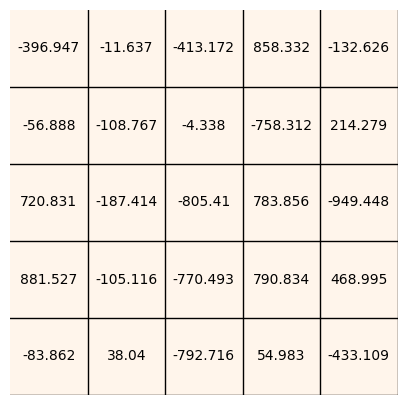

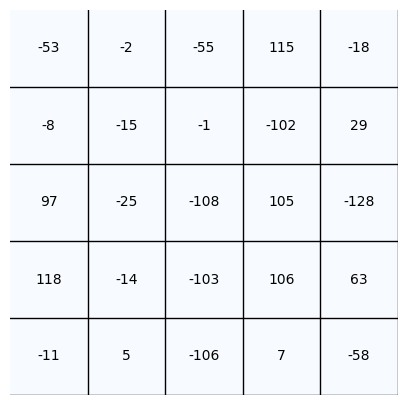

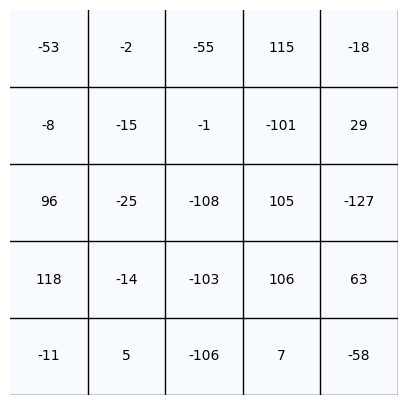

In [3]:
plot_table(data, str(OUTPUT_DIR / "unquantized-data.png"), "Oranges", "black", "black")
plot_table(
    quantized_symmetric_full_data,
    str(OUTPUT_DIR / "quantized-symmetric-full.png"),
    "Blues",
    "black",
    "black",
)
plot_table(
    quantized_symmetric_restricted_data,
    str(OUTPUT_DIR / "quantized-symmetric-restricted.png"),
    "Blues",
    "black",
    "black",
)